In [1]:
import sqlite3
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# db files
disk_db_file = "./sample_data/disk/database.db"
colmap_sift_db_file = "./sample_data/colmap/database.db"
merged_db_file = "./sample_data/merged_database.db"

In [3]:
# connection
disk_conn = sqlite3.connect(disk_db_file)
colmap_sift_conn = sqlite3.connect(colmap_sift_db_file)
merged_conn = sqlite3.connect(merged_db_file)

# cursor
disk_cursor = disk_conn.cursor()
colmap_sift_cursor = colmap_sift_conn.cursor()
merged_cursor = merged_conn.cursor()

In [4]:
MAX_IMAGE_ID = 2**31 - 1


def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % MAX_IMAGE_ID
    image_id1 = (pair_id - image_id2) / MAX_IMAGE_ID
    return image_id1, image_id2


def blob_to_array(blob, dtype, shape=(-1,)):
    if blob is None:
        return []
    return np.frombuffer(blob, dtype=dtype).reshape(*shape)

In [5]:
def get_image_ids_to_image_names(cursor):
    cursor.execute("SELECT image_id, name FROM images;")
    image_ids_to_image_names = {}
    for row in cursor.fetchall():
        image_ids_to_image_names[row[0]] = row[1]
    return image_ids_to_image_names

# get image ids to image names
disk_image_ids_to_image_names = get_image_ids_to_image_names(disk_cursor)
colmap_sift_image_ids_to_image_names = get_image_ids_to_image_names(colmap_sift_cursor)
merged_image_ids_to_image_names = get_image_ids_to_image_names(merged_cursor)

print(disk_image_ids_to_image_names)
print(colmap_sift_image_ids_to_image_names)
print(merged_image_ids_to_image_names)
disk_image_ids_to_image_names == colmap_sift_image_ids_to_image_names == merged_image_ids_to_image_names

{1: '0.jpg', 2: '1.jpg', 3: '10.jpg', 4: '11.jpg', 5: '12.jpg', 6: '13.jpg', 7: '14.jpg', 8: '15.jpg', 9: '16.jpg', 10: '17.jpg', 11: '18.jpg', 12: '19.jpg', 13: '2.jpg', 14: '20.jpg', 15: '21.jpg', 16: '22.jpg', 17: '3.jpg', 18: '4.jpg', 19: '5.jpg', 20: '6.jpg', 21: '7.jpg', 22: '8.jpg', 23: '9.jpg'}
{1: '0.jpg', 2: '1.jpg', 3: '10.jpg', 4: '11.jpg', 5: '12.jpg', 6: '13.jpg', 7: '14.jpg', 8: '15.jpg', 9: '16.jpg', 10: '17.jpg', 11: '18.jpg', 12: '19.jpg', 13: '2.jpg', 14: '20.jpg', 15: '21.jpg', 16: '22.jpg', 17: '3.jpg', 18: '4.jpg', 19: '5.jpg', 20: '6.jpg', 21: '7.jpg', 22: '8.jpg', 23: '9.jpg'}
{1: '0.jpg', 2: '1.jpg', 3: '10.jpg', 4: '11.jpg', 5: '12.jpg', 6: '13.jpg', 7: '14.jpg', 8: '15.jpg', 9: '16.jpg', 10: '17.jpg', 11: '18.jpg', 12: '19.jpg', 13: '2.jpg', 14: '20.jpg', 15: '21.jpg', 16: '22.jpg', 17: '3.jpg', 18: '4.jpg', 19: '5.jpg', 20: '6.jpg', 21: '7.jpg', 22: '8.jpg', 23: '9.jpg'}


True

In [6]:
# function to get keypoints
def get_keypoints(cursor, method: str):
    # preprocess keypoints
    if method == "disk":
        keypoints = dict(
            (image_id, blob_to_array(data, np.float32, (-1, 2)))
            for image_id, data in cursor.execute("SELECT image_id, data FROM keypoints")
        )
    elif method == "colmap":
        keypoints = dict(
            (image_id, blob_to_array(data, np.float32, (-1, 6)))
            for image_id, data in cursor.execute("SELECT image_id, data FROM keypoints")
        )
    return keypoints


colmap_keypoints = get_keypoints(colmap_sift_cursor, method="colmap")
disk_keypoints = get_keypoints(disk_cursor, method="disk")
merged_keypoints = get_keypoints(merged_cursor, method="disk")



In [7]:
def vis_image_pair_keypoints(
    img1, img2, img_1_matched_keypoint, img_2_matched_keypoint, img_id1_name, img_id2_name,color
):
    # visualize keypoint
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.scatter(
        img_1_matched_keypoint[:, 0], img_1_matched_keypoint[:, 1], s=1, c=color
    )
    plt.title(img_id1_name)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.scatter(
        img_2_matched_keypoint[:, 0], img_2_matched_keypoint[:, 1], s=1, c=color
    )
    plt.title(img_id2_name)
    plt.axis("off")
    plt.show()


# def vis_image_pair_keypoint_matches(
#     img1,
#     img2,
#     img_1_matched_keypoint,
#     img_2_matched_keypoint,
#     img_id1_name,
#     img_id2_name,
#     matches,
#     color=(0, 255, 0),
# ):
#     # Convert images to RGB (OpenCV uses BGR by default)
#     img1_rgb = img1.copy()
#     img2_rgb = img2.copy()

#     # convert keypoints to cv2 keypoints
#     img1_kp = [cv2.KeyPoint(x, y, 1) for x, y in img_1_matched_keypoint]
#     img2_kp = [cv2.KeyPoint(x, y, 1) for x, y in img_2_matched_keypoint]

#     # cv2.drawMatches
#     # Convert matches to cv2 DMatch
#     cv2_matches = [cv2.DMatch(i, i, 0) for i in range(len(matches))]

#     # Draw matches
#     img_matches = cv2.drawMatches(
#         img1_rgb,
#         img1_kp,
#         img2_rgb,
#         img2_kp,
#         cv2_matches,
#         None,
#         matchColor=color + (130,),  # Add thickness to color tuple
#         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
#     )

#     # Display the output image
#     plt.figure(figsize=(15, 15))
#     plt.imshow(img_matches)
#     plt.title(f"{img_id1_name} and {img_id2_name}")
#     plt.axis("off")
#     plt.show()


def vis_image_pair_keypoint_matches(
    img1,
    img2,
    img_1_matched_keypoint,
    img_2_matched_keypoint,
    img_id1_name,
    img_id2_name,
    matches,
    color=(0, 255, 0),
    line_thickness=5,  # Adjust line thickness for matches
    keypoint_size=20,  # Adjust keypoint size
):
    # Convert images to RGB (OpenCV uses BGR by default)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    
    # draw keypoint as circle
    for point in img_1_matched_keypoint:
        cv2.circle(img1_rgb, (int(point[0]), int(point[1])), keypoint_size, color, -1)
    for point in img_2_matched_keypoint:
        cv2.circle(img2_rgb, (int(point[0]), int(point[1])), keypoint_size, color, -1)
    

    # Convert keypoints to cv2.KeyPoint objects
    img1_kp = [cv2.KeyPoint(x, y, keypoint_size) for x, y in img_1_matched_keypoint]
    img2_kp = [cv2.KeyPoint(x, y, keypoint_size) for x, y in img_2_matched_keypoint]

    # Create cv2 DMatch objects
    cv2_matches = [cv2.DMatch(i, i, 0) for i in range(len(matches))]
    

    # Draw matches between the images
    img_matches = cv2.drawMatches(
        img1_rgb,
        img1_kp,
        img2_rgb,
        img2_kp,
        cv2_matches,
        None,
        matchColor=color,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        singlePointColor=(255, 0, 0),
        matchesThickness=line_thickness,
        # lineThickness=line_thickness,  # Increase thickness of the line
    )

    # Display the output image
    plt.figure(figsize=(15, 15))
    plt.imshow(img_matches)
    plt.title(f"{img_id1_name} and {img_id2_name}")
    plt.axis("off")
    plt.show()

# **matches table validation**

In [8]:
# matches
def get_matches(cursor):
    matches = dict(
        (pair_id, blob_to_array(data, np.uint32, (-1, 2)))
        for pair_id, data in cursor.execute("SELECT pair_id, data FROM matches")
    )
    return matches


colmap_matches = get_matches(colmap_sift_cursor)
disk_matches = get_matches(disk_cursor)
merged_matches = get_matches(merged_cursor)

# pair id validation
print(colmap_matches.keys() == disk_matches.keys())  # passed
print(colmap_matches.keys() == disk_matches.keys() == merged_matches.keys())  # passed

True
False


In [24]:
list(merged_matches.keys())[10:30]

[2147483660,
 2147483661,
 2147483662,
 2147483663,
 2147483664,
 2147483665,
 2147483666,
 2147483667,
 2147483668,
 2147483669,
 2147483670,
 4294967298,
 4294967299,
 4294967300,
 4294967301,
 4294967302,
 4294967303,
 4294967304,
 4294967305,
 4294967306]

In [25]:
# match keypoint index validation for a pair id
pair_id = 4294967299
img_id1, img_id2 = pair_id_to_image_ids(pair_id)
img_id1_name = disk_image_ids_to_image_names[img_id1]
img_id2_name = disk_image_ids_to_image_names[img_id2]


print(img_id1_name, img_id2_name)
# read images
img1 = cv2.imread(f"./sample_data/preprocessed_images/{img_id1_name}")
img2 = cv2.imread(f"./sample_data/preprocessed_images/{img_id2_name}")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

1.jpg 12.jpg


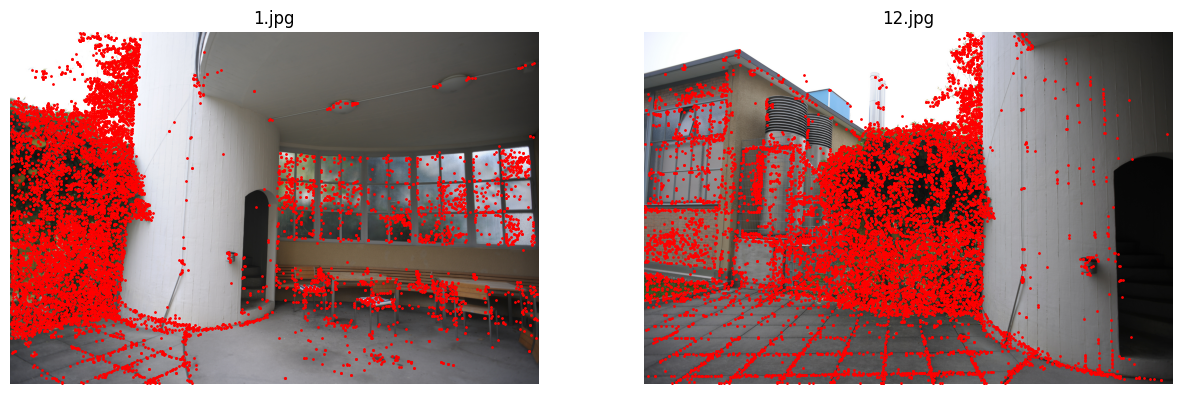

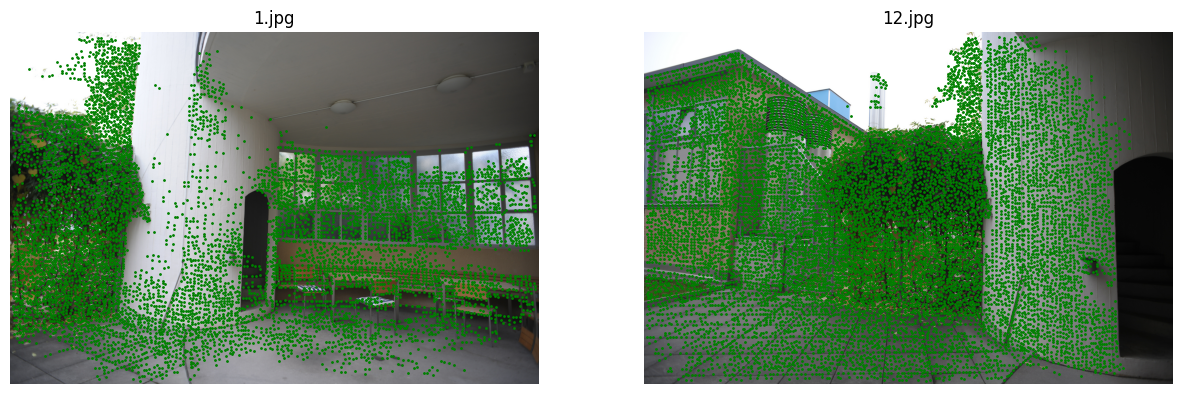

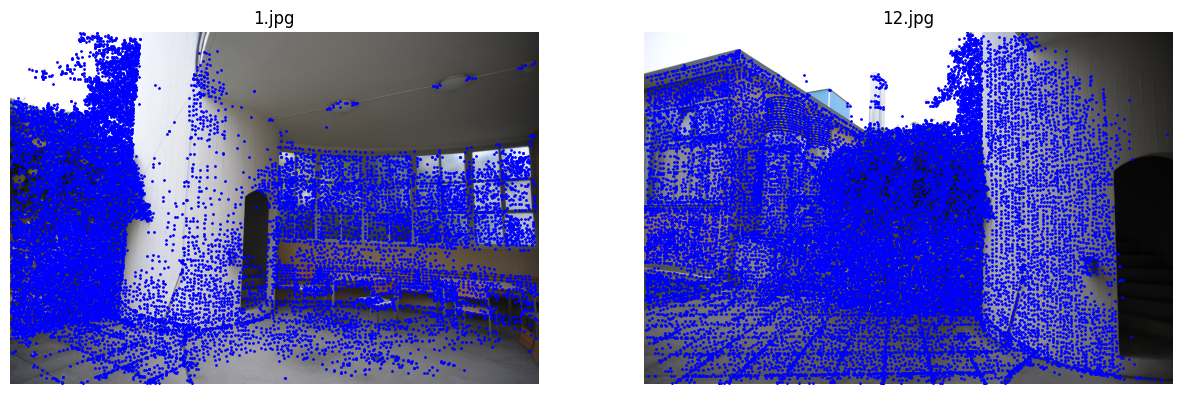

(9362, 2) (7532, 2) (16894, 2)
(10806, 2) (11471, 2) (22277, 2)


In [26]:
# get keypoints for the pair
img_1_colmap_keypoints = colmap_keypoints[img_id1][:, :2]
img_2_colmap_keypoints = colmap_keypoints[img_id2][:, :2]
# visualize keypoint
vis_image_pair_keypoints(img1=img1, img2=img2, img_1_matched_keypoint=img_1_colmap_keypoints, img_2_matched_keypoint=img_2_colmap_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, color='r')


img_1_disk_keypoints = disk_keypoints[img_id1]
img_2_disk_keypoints = disk_keypoints[img_id2]
vis_image_pair_keypoints(img1=img1, img2=img2, img_1_matched_keypoint=img_1_disk_keypoints, img_2_matched_keypoint=img_2_disk_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, color='g')

img_1_merged_keypoints = merged_keypoints[img_id1]
img_2_merged_keypoints = merged_keypoints[img_id2]
vis_image_pair_keypoints(img1=img1, img2=img2, img_1_matched_keypoint=img_1_merged_keypoints, img_2_matched_keypoint=img_2_merged_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, color='b')

print(img_1_colmap_keypoints.shape, img_1_disk_keypoints.shape, img_1_merged_keypoints.shape)
print(img_2_colmap_keypoints.shape, img_2_disk_keypoints.shape, img_2_merged_keypoints.shape)

4294967299
(116, 2) (537, 2) (653, 2)


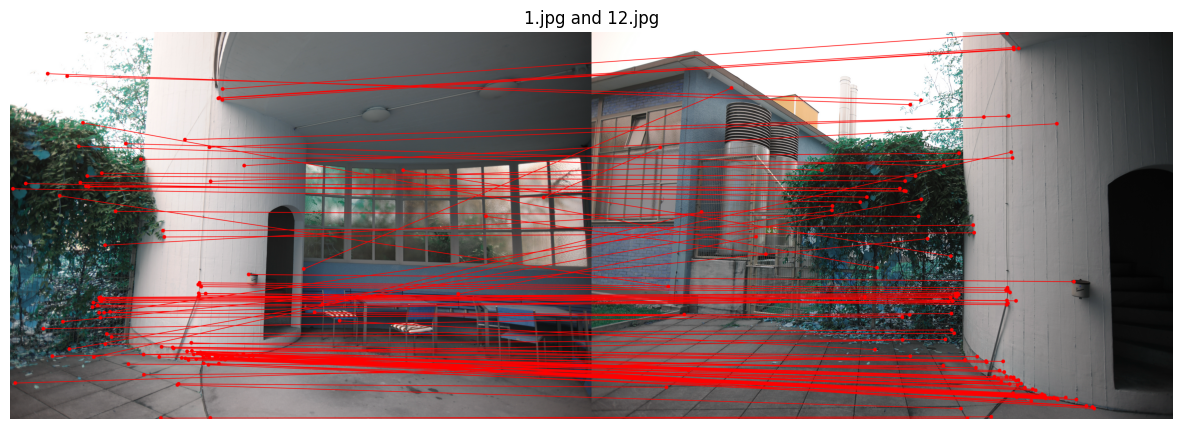

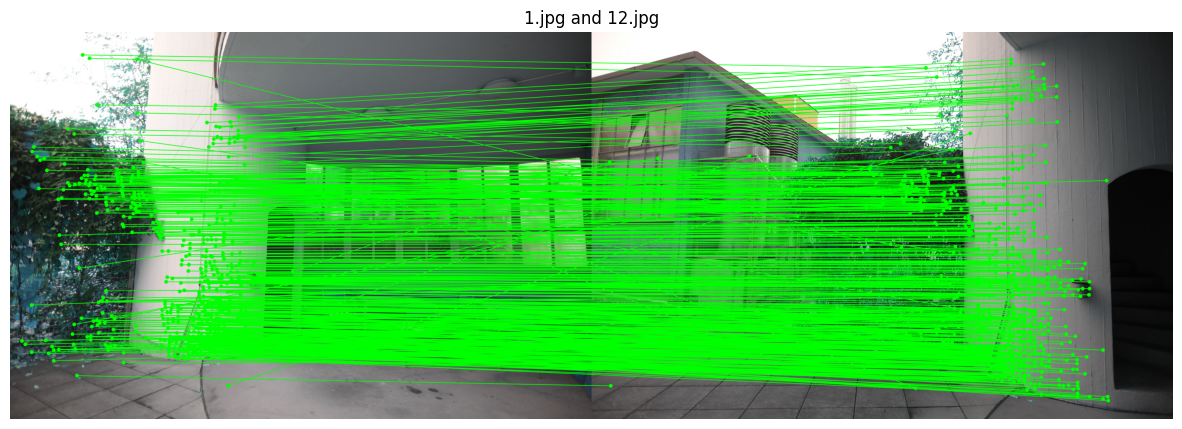

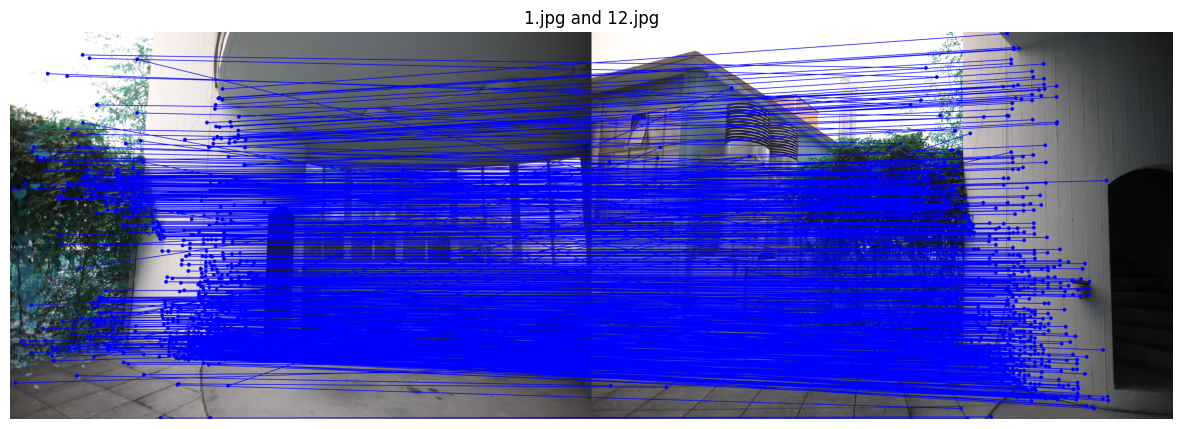

(116, 2) (537, 2) (653, 2)
(116, 2) (537, 2) (653, 2)


In [27]:
# filter keypoints based on matches
import random
colmap_image_pair_matches = colmap_matches[pair_id]
disk_image_pair_matches = disk_matches[pair_id]
merged_image_pair_matches = merged_matches[pair_id]

print(pair_id)
print(colmap_image_pair_matches.shape, disk_image_pair_matches.shape, merged_image_pair_matches.shape)

colmap_img_1_filted_keypoints = img_1_colmap_keypoints[colmap_image_pair_matches[:, 0]]
colmap_img_2_filted_keypoints = img_2_colmap_keypoints[colmap_image_pair_matches[:, 1]]

# visualize keypoint
# vis_image_pair_keypoints(img1=img1, img2=img2, img_1_matched_keypoint=colmap_img_1_filted_keypoints, img_2_matched_keypoint=colmap_img_2_filted_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, color='r')
vis_image_pair_keypoint_matches(img1=img1, img2=img2, img_1_matched_keypoint=colmap_img_1_filted_keypoints, img_2_matched_keypoint=colmap_img_2_filted_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, matches=colmap_image_pair_matches, color=(255, 0, 0))

disk_img_1_filted_keypoints = img_1_disk_keypoints[disk_image_pair_matches[:, 0]]
disk_img_2_filted_keypoints = img_2_disk_keypoints[disk_image_pair_matches[:, 1]]

# visualize keypoint
# vis_image_pair_keypoints(img1=img1, img2=img2, img_1_matched_keypoint=disk_img_1_filted_keypoints, img_2_matched_keypoint=disk_img_2_filted_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, color='g')
vis_image_pair_keypoint_matches(img1=img1, img2=img2, img_1_matched_keypoint=disk_img_1_filted_keypoints, img_2_matched_keypoint=disk_img_2_filted_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, matches=disk_image_pair_matches, color=(0, 255, 0))

merged_img_1_filted_keypoints = img_1_merged_keypoints[merged_image_pair_matches[:, 0]]
merged_img_2_filted_keypoints = img_2_merged_keypoints[merged_image_pair_matches[:, 1]]

# visualize keypoint
# vis_image_pair_keypoints(img1=img1, img2=img2, img_1_matched_keypoint=merged_img_1_filted_keypoints, img_2_matched_keypoint=merged_img_2_filted_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, color='b')
vis_image_pair_keypoint_matches(img1=img1, img2=img2, img_1_matched_keypoint=merged_img_1_filted_keypoints, img_2_matched_keypoint=merged_img_2_filted_keypoints, img_id1_name=img_id1_name, img_id2_name=img_id2_name, matches=merged_image_pair_matches, color=(0, 0, 255))

print(colmap_img_1_filted_keypoints.shape, disk_img_1_filted_keypoints.shape, merged_img_1_filted_keypoints.shape)
print(colmap_img_2_filted_keypoints.shape, disk_img_2_filted_keypoints.shape, merged_img_2_filted_keypoints.shape)


# disk matching validation from merged keypoint and matching 
